# Inferring the Vehicle Type with Neural Networks

Ruggero Fabbiano – 25 February 2021

## Introduction

In a previous exploratory notebook (*Analysis of Urban-Traffic Simulated Data – part II*) we noticed an issue with pedestrians objects in SUMo MoST: a lot of the objects classified as pedestrians actually show a behaviour that is not really belonging to this class. The idea behind this notebook is to use deep learning to correctly classify the type of such vehicles.

#### Why Deep Learning?

Our data set can be thought as composed by multi-variate time-series (after proper manipulation) of vehicle trips around the Monaco area. As we know, the `sktime` package (a kind of "SKLearn version for time-series") has been conceived to treatspecifically this kind of data, and is supposed to provide better results than deep learning for multi-variate classification. So why deep learning?

The answer is that this article is meant to provide a "comparison" (or better, a parallel work) with our other vehicle classification work that already uses SKTime (*Vehicle Type Prediction Using Simulated Trajectory Data*, by Pedro Venturott), to help us understand if there is a better way to approach such problem, and if so, what it is.

## The Data

For the sake of comprehension we will use here the same data used in the exploratory notebook cited here above (_Urban Traffic Data Statistical Analysis_, see section _Save the data on-file_). Moreover, we suppose to have already carried out all the "data cleaning" that is done there.
    
We can then proceed to import the data previously saved, after installing and importing the needed packages.

## Install Needed Packages

In [1]:
!pip install pandas
!pip install seaborn
!pip install sklearn
!pip install tensorflow

## Import Packages and Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras import Sequential

plt.style.use('bmh')

In [3]:
data = pd.read_pickle("MoST_0600_0830_processed.pkl") # data before dropping some vehicle types
temp = pd.read_pickle("ped_reclassified.pkl") # data with re-classified type for wrong pedestrians ("type_p")
data['type_p']=temp['type_p']
del temp
data.head()

,t,angle,ID,lane_edge,position,slope,speed,type,x,y,z,time,type_p
2,21600.0,50.48,pedestrian_2-1_3985_tr,153330#1_1,2.2,-1.57,0.0,moped,4811.50,2704.21,143.81,06:00:00,moped
3,21600.0,50.48,pedestrian_2-1_3985,153330#1,2.20,-1.55,0.0,pedestrian,4811.50,2704.21,143.81,06:00:00,moped
4,21600.0,307.42,pedestrian_2-1_5063_tr,152413#3_1,2.3,-6.20,0.0,motorcycle,2006.06,3313.49,400.40,06:00:00,motorcycle
5,21600.0,307.42,pedestrian_2-1_5063,152413#3,2.30,-6.20,0.0,pedestrian,2006.06,3313.49,400.40,06:00:00,motorcycle
6,21600.0,121.94,pedestrian_2-1_5887_tr,-152557#1_1,2.3,-0.04,0.0,motorcycle,6482.50,3763.28,57.60,06:00:00,motorcycle


## Framing the Problem

As we already said in the introduction, we want to classify vehicles; in particular, we want to re-classify objects that the MoST scenario wrongly labels as pedestrianss.

Dealing with deep learning and multi-variate time-series, we have two main approaches to choose from:
* Perform a feature-engineering task to extract static features from the time-series (*e.g.*, average speed, time spend queueing, max. speed, max. acceleration and so on), and then fed them to any standard classification algorithm.
* Use our dataframe as-is (that of course, is never really *as-is*...) and using directly time-series as our to-be-classified data; in this second case we can:
    * split the time-series into several fixed-length windows and feed them directly to a convolutional neural network, that basically does the feature extraction on its own;
    * use a neural network that is a _sequence model_, which naturally consumes time-series data.

To fully exploit the *time-series* data property we will use this second approach, even if it could prove to be more complex / resource-intensive. In particular, **we will build a recurrent neural network**, that can be directly fed with time-series data.

## Selecting the Good Features

The first step is obviously to select the good features for our classification problem. Let's recapitulate them:

In [4]:
data.columns

Index(['t', 'angle', 'ID', 'lane_edge', 'position', 'slope', 'speed', 'type',
       'x', 'y', 'z', 'time', 'type_p'],
      dtype='object')

* Paradoxically for a work intended to be on time-series, we won't need the time information (`t` and `time`): we already know the organisation of our data, and know that entries are ranged by time stamp (with a fixed time-step equal to 5 s), thus it's not necessary to keep such information.
* We will surely keep the `ID`, because it's what will make us distinguish the different time-series.
* `angle`, `position`, `slope`, `x`, `y`, `z` are "tolopogical" variables related to the lane the vehicle is in, so probably not very interesting; at the same time, their being numeric can prove useful as opposed to `lane_edge`, which can be too complicated to use.
* As said before, `lane_edge` associated with the time information can help us dissociate the intrinsic vehicle behaviour from the traffic conditions; at the same time, encoding all the possible lanes can become challenging.
* `speed` and `type`/`type_p` are without any doubt the most important features: the first one is the one that probably better describes a vehicle behaviour, while the latter will be our classification goal.

In conclusion, keeping the `x`/`y` position instead of the lane information will probably prove wiser. Let's proceed:

In [5]:
data = data[['ID', 'x', 'y', 'speed', 'type', 'type_p']]
data.head()

,ID,x,y,speed,type,type_p
2,pedestrian_2-1_3985_tr,4811.50,2704.21,0.0,moped,moped
3,pedestrian_2-1_3985,4811.50,2704.21,0.0,pedestrian,moped
4,pedestrian_2-1_5063_tr,2006.06,3313.49,0.0,motorcycle,motorcycle
5,pedestrian_2-1_5063,2006.06,3313.49,0.0,pedestrian,motorcycle
6,pedestrian_2-1_5887_tr,6482.50,3763.28,0.0,motorcycle,motorcycle


Let us also check that our feature values are well-formatted numeric (we already checked it for speed in the previous notebook):

In [6]:
def process_values(x):
    try: return float(x)
    except ValueError: return np.NaN # we might have abnormal values

data[['x', 'y']] = data[['x', 'y']].applymap(process_values)

Were there anomalous values?

In [7]:
anomalies = data[(data['x'].isna()) | (data['y'].isna())]
anomalies

,ID,x,y,speed,type,type_p
1024317,pedestrian_1-2_2838_tr,NaN,NaN,9.936,motorcycle,motorcycle
1024318,pedestrian_1-2_2838,NaN,NaN,9.936,pedestrian,motorcycle
2923468,pedestrian_1-2_4375_tr,NaN,NaN,19.584,motorcycle,motorcycle
2923469,pedestrian_1-2_4375,NaN,NaN,19.584,pedestrian,motorcycle


Only 4, let's drop them. We'll drop the whole time-series to avoid incoherences due to holes in the data series; also, since they are very few, it is not worth to fine-work on the relative time-series to impute them.

In [8]:
data = data[~data['ID'].isin(anomalies['ID'].unique())]

## Selecting Time-Series

Before splitting our data set, we have to set a uniform length for our time-series: let's choose 20 minutes as the default length.

Thus, we have to filter out vehicles with a shorter travel time:

In [9]:
TS_lengths = data.groupby('ID')['speed'].count()
L = 20 * 60 / 5 # number of desired steps: minutes / seconds-per-minute * time_step
usable_obj = TS_lengths[TS_lengths>=L].index

data = data[data['ID'].isin(usable_obj)]

## Splitting the Data Set

The next step is divide our data set into training and testing sets. First we have to take out the pedestrians we want to re-classify, as this will be our "production inference" data set; then we have to get train and test sets from the remaining data.

The first problem we have to face is: how can we separate "true" pedestrians from false ones? We need to have some ground truth of pedestrians to train our network. Let's simply check if speed can help us doing so.

Before starting, how many possible pedestrians we have?

In [10]:
all_ped = data[data['type']=='pedestrian']['ID'].unique()
all_obj = data['ID'].unique()

print(F"{len(all_ped)} pedestrians out of {len(all_obj)} objects")

4967 pedestrians out of 12489 objects


A bit more than 1/3, knowing (from our previous notebook) that before filtering out time-series they were a half: we have dropped a lot of pedestrians!

Thinking about speed to confirm the "pedestrian" type, we know from the [SUMo vehicle type parameter defaults](https://sumo.dlr.de/docs/Vehicle_Type_Parameter_Defaults.html) that $ v_{\rm{ped}} = 5.4 $ km/h, with $ \sigma = 0.1 $; thus, more than 99 % of pedestrians should have $ v_{\rm{max}} \le 5.7 $ km/h. Let's choose $6$ km/h as a limit.

In [11]:
ped_v_max = data[data['type']=='pedestrian'].groupby('ID')['speed'].max()

In [12]:
real_ped = ped_v_max[ped_v_max<6]

len(real_ped)

46

46! Less than 1 % of the total "possible pedestrians" have a speed lower than the maximum declared!

Let's do a kind of "sanity check" on these 46 using acceleration. [SUMo vehicle type parameter defaults](https://sumo.dlr.de/docs/Vehicle_Type_Parameter_Defaults.html) tells us also that $ -2 \le a \le 1.5 $ m/s², with the same standard deviation as for speed; thus, more than 99 % of pedestrians should have $ -2.3 \le a \le 1.8 $ m/s². Let's choose $ a_{\rm{min}} = -2.5 $ and $ a_{\rm{max}} = 2 $ m/s².

In [13]:
ped_speeds = data[data['type']=='pedestrian'][['ID', 'speed']]
real_ped = pd.DataFrame(real_ped)

In [14]:
def get_acc_peaks(ID):
    acc = ped_speeds[ped_speeds['ID']==ID]['speed'].diff()[1:]/5/3.6 # m/s^2
    try:
        return min(acc), max(acc)
    except ValueError:
        return 0, 0

def set_acc_peaks(DF):
    ind, acc_min, acc_max = [], [], []
    for obj_ID, _ in DF.iterrows():
        m, M = get_acc_peaks(obj_ID)
        ind.append(obj_ID)
        acc_min.append(m)
        acc_max.append(M)
    return pd.DataFrame({"min.": acc_min, "max.": acc_max}, index=DF.index)

In [15]:
real_ped[["a min.", "a max."]] = set_acc_peaks(real_ped)

In [16]:
assert real_ped[real_ped['a min.']<-2.5].empty
assert real_ped[real_ped['a max.']>2].empty

OK, those will then be our "real" pedestrians. The remaining ones will be our classification target.

In [17]:
to_classify = data[data['ID'].isin(ped_v_max[ped_v_max>6].index)]
train_test_data = data[~data['ID'].isin(to_classify['ID'])]

How many objects we have to classify, and with how many objects to train our model?

In [18]:
len(to_classify['ID'].unique()), len(train_test_data['ID'].unique())

(4921, 7568)

Good. Before moving further, let's look how our data set is (un)balanced... 

In [19]:
object_type = train_test_data.groupby('ID')['type'].min()
n_obj = len(object_type)
for obj_type in object_type.unique():
    n_type = len(object_type[object_type==obj_type])
    print(obj_type + F": {n_type} ({n_type/n_obj:.2%})")

bus: 108 (1.43%)
lorry: 28 (0.37%)
delivery: 108 (1.43%)
pedestrian: 46 (0.61%)
bicycle: 9 (0.12%)
motorcycle: 1327 (17.53%)
moped: 579 (7.65%)
car: 5309 (70.15%)
hire: 5 (0.07%)
special: 49 (0.65%)


Let's drop for sure private hire vehicles and bicycles: they are too few to be used.

We could think about dropping pedestrians, since we already know that what we want to classify are not pedestrians; anyway, we might end up reclassifying some of them as such.

Then we can take all the other instances of types that have less than 150 objects, and sample 150 instances for the others. The data set will be a bit unbalanced like this, but we will see how the model behaves.

In [20]:
train_test_data = train_test_data[~train_test_data['type'].isin(['bicycle', 'hire'])]

In [21]:
to_sample = ['moped', 'motorcycle', 'car']
IDs = []
for v_type in to_sample:
    IDs.extend(object_type[object_type==v_type].sample(150, random_state=1).index)

In [22]:
train_test_data = train_test_data[~((train_test_data['type'].isin(to_sample)) &
                                    (~train_test_data['ID'].isin(IDs)))]

Now we have to split our training data set; let's the standard ratio of 1:3 for each vehicle type.

In [23]:
test_IDs = []
for v_type in train_test_data['type'].unique():
    single_type = train_test_data[train_test_data['type']==v_type]['ID'].unique()
    test_IDs.extend(np.random.choice(single_type, int(len(single_type)*0.25)))

train_data = train_test_data[~train_test_data['ID'].isin(test_IDs)]
test_data = train_test_data[train_test_data['ID'].isin(test_IDs)]

In [24]:
len(train_data['ID'].unique()), len(test_data['ID'].unique())

(611, 178)

## Creating Vectors

We have a lot of different features, better scale them... But before we have to make sure that to-classify data don't contain vehicle type that have been removed from training!

In [25]:
to_classify = to_classify[to_classify['type_p'].isin(train_test_data['type'].unique())]

In [26]:
features = ['x', 'y', 'speed']

scaler = RobustScaler()
scaler = scaler.fit(train_data[features])
train_data.loc[:, features] = scaler.transform(train_data[features].to_numpy())
test_data.loc[:, features] = scaler.transform(test_data[features].to_numpy())
to_classify.loc[:, features] = scaler.transform(to_classify[features].to_numpy())

C:\Users\rugge\Anaconda\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\rugge\Anaconda\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Time to prepare our sets for the model!

In [27]:
def create_learning_vectors(dataset, X_features=features, l_max=int(L), y_feature='type'):
    X, y = [], []
    for obj in dataset['ID'].unique():
        obj_data = dataset[dataset['ID']==obj]
        X.append(obj_data.iloc[:l_max][X_features].values)
        y.append(obj_data[y_feature].unique())
    return np.array(X), np.array(y)

Playing the next cell can be the right moment to grab a coffee...

In [28]:
%%time

X_train, y_train = create_learning_vectors(train_data)
X_test, y_test = create_learning_vectors(test_data)
X_to_classify, y_to_classify = create_learning_vectors(to_classify, y_feature='type_p')

Wall time: 8min 15s


One last thing: we have to encode the output categorical variables!

In [29]:
encoder = OneHotEncoder(sparse=False)
encoder = encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
y_to_classify = encoder.transform(y_to_classify)

## Building the Classification Model

Time to build our model and see how it performs!

As we said previously, we are going to implement a recurrent neural network (RNN) architecture; in particular, the so-called *Long Short-Term Memory* (LSTM) RNN.

Unlike standard feedforward neural networks, LSTM has feedback connections; this makes such networks well-suited to classifying, processing and making predictions based on time-series data. You can read [the LSTM Wikipedia page](https://en.wikipedia.org/wiki/Long_short-term_memory) for more information.

### Model Hyper-Parameters

As a choice for the network implementation (welcome to the magical world of hyper-parameter tuning, covered by a dense fog and populated by rules of thumb :)), we opt for the following structure:
* one bi-directional layer (for the sake of rapidity – adding a second slowed it down to a point that I didn't even get to see if it improved the output metrics!);
* a drop-out layer (that should always be present to avoid over-fitting), with the "conventional" choice of 0.2 as a drop-out factor;
* a standard layer with the basic ReLU activation function;
* a final layer, the same size as the output, with the softmax activation function which is best suited for classification problems (the same reson apply for the choice of the compile parameters).

The choice of 128 units gives us a good compromise time/performances (choosing 256 units also slowed down a lot).

In [30]:
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(128)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Last parameters before fitting the model!
The following choices come after some simple intuition mixed to some trial and error (done in previous iterations):
* a batch size of 50 fits well into a data set composed by 551 samples, with a good trade-off between rapidity and quality;
* 25 epochs is the number that gave the best outcome, as 20 showed that there was room for further amelioration, and 30 allowed to see that accuracy was degrading again around 25;
* the cross-validation ratio is kept lower, since the size of our data set is not huge (in any case 0.1 it's a pretty conventional ratio).

Let's go!

In [31]:
LSTM_RNN = model.fit(X_train, y_train, batch_size=50, epochs=25, validation_split=0.1)

Train on 549 samples, validate on 62 samples
Epoch 1/25
549/549 [==============================] - 11s 20ms/sample - loss: 1.7764 - accuracy: 0.3643 - val_loss: 1.8111 - val_accuracy: 0.3387
Epoch 2/25
549/549 [==============================] - 7s 13ms/sample - loss: 1.2791 - accuracy: 0.5756 - val_loss: 1.5753 - val_accuracy: 0.4032
Epoch 3/25
549/549 [==============================] - 8s 15ms/sample - loss: 1.0106 - accuracy: 0.6412 - val_loss: 1.2741 - val_accuracy: 0.4839
Epoch 4/25
549/549 [==============================] - 9s 16ms/sample - loss: 0.8449 - accuracy: 0.6903 - val_loss: 1.1281 - val_accuracy: 0.6290
Epoch 5/25
549/549 [==============================] - 9s 16ms/sample - loss: 0.7375 - accuracy: 0.7268 - val_loss: 1.1582 - val_accuracy: 0.6129
Epoch 6/25
549/549 [==============================] - 9s 17ms/sample - loss: 0.6649 - accuracy: 0.7559 - val_loss: 1.0692 - val_accuracy: 0.6613
Epoch 7/25
549/549 [==============================] - 9s 16ms/sample - loss: 0.5887 

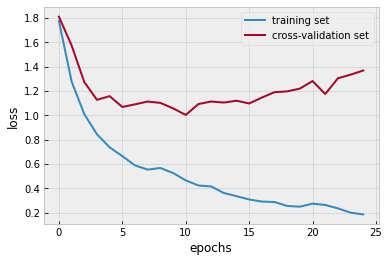

In [32]:
plt.plot(LSTM_RNN.history['loss'], label='training set')
plt.plot(LSTM_RNN.history['val_loss'], label='cross-validation set')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend();

Time to evaluate our model on the true test set!

In [33]:
model.evaluate(X_test, y_test)

178/178 [==============================] - 1s 3ms/sample - loss: 0.6265 - accuracy: 0.7584


[0.6265052891849132, 0.75842696]

In [34]:
y_pred = model.predict(X_test)

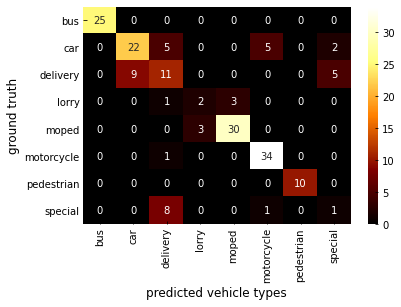

In [35]:
ground_truth = encoder.inverse_transform(y_test)
predictions = encoder.inverse_transform(y_pred)
CM = confusion_matrix(ground_truth, predictions)

_, ax = plt.subplots() 
ax = sns.heatmap(CM, annot=True, fmt="d", cmap='afmhot')
plt.ylabel('ground truth')
plt.xlabel('predicted vehicle types')
ax.set_xticklabels(encoder.categories_[0], rotation='vertical')
ax.set_yticklabels(encoder.categories_[0], rotation='horizontal');

It doesn't look that bad!

Since our data set was not really balanced, let's look at its F1 as well. Given the type of problem (multi-variate classification) this is not immediate; let's compute it for each vehicle type, as well as the average one.

In [36]:
precisions = pd.Series([CM[i, i]/sum(CM[:, i]) for i in range(CM.shape[1])], name="Precision")
recalls = pd.Series([CM[i, i]/sum(CM[i, :]) for i in range(CM.shape[0])], name="Recall")
F1s = pd.Series([2*(p*r)/(p+r) for p,r in zip(precisions, recalls)], name="F1")

metrics = pd.DataFrame([precisions, recalls, F1s]).transpose().set_index(encoder.categories_[0])

prec = np.mean(precisions)
rec = np.mean(recalls)
F1 = 2*(prec*rec)/(prec+rec)

metrics.append(pd.Series([prec, rec, F1], name="GLOBAL", index=["Precision", "Recall", "F1"]))

,Precision,Recall,F1
bus,1.000000,1.000000,1.000000
car,0.709677,0.647059,0.676923
delivery,0.423077,0.440000,0.431373
lorry,0.400000,0.333333,0.363636
moped,0.909091,0.909091,0.909091
motorcycle,0.850000,0.971429,0.906667
pedestrian,1.000000,1.000000,1.000000
special,0.125000,0.100000,0.111111
GLOBAL,0.677106,0.675114,0.676108


## Time to Test on Our Original Problem!

So... what was all it for? Of course we did something interesting (at least we hope), but at this point it may be interesting to compare our "hand-made" prediction with our LSTM network. How much will the classification differ? Let's do it!

In [37]:
model.evaluate(X_to_classify, y_to_classify)

4916/4916 [==============================] - 15s 3ms/sample - loss: 2.1035 - accuracy: 0.3169


[2.1034522574543466, 0.31692433]

In [38]:
y_classified = model.predict(X_to_classify)

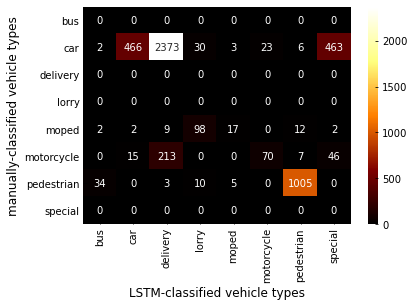

In [39]:
ground_truth = encoder.inverse_transform(y_to_classify)
predictions = encoder.inverse_transform(y_classified)
CM = confusion_matrix(ground_truth, predictions)

_, ax = plt.subplots() 
ax = sns.heatmap(CM, annot=True, fmt="d", cmap='afmhot')
plt.ylabel('manually-classified vehicle types')
plt.xlabel('LSTM-classified vehicle types')
ax.set_xticklabels(encoder.categories_[0], rotation='vertical')
ax.set_yticklabels(encoder.categories_[0], rotation='horizontal');

Luckily, not really the same!

In [40]:
same_type = sum(CM[i][i] for i in range(CM.shape[0]))
total_obj = sum(sum(CM))
print(F"Vehicles classified as the same type: {same_type} out of {total_obj} ({same_type/total_obj:.2%})")

Vehicles classified as the same type: 1558 out of 4916 (31.69%)


## Conclusions and open questions

In this notebook we showed how to build a simple LSTM network to classify vehicle types from timeseries data. The data we used is generated by a traffic simulator and resembles the GPS traces of objects in a city.

We found that the LSTM, despite being simple and lightweight, achieves good performances! It's interesting especially to compare how the network in this article does with respect to the models in the SKTime package, that were explored in an another article (see _Vehicle Type Prediction_, Pedro Venturott).

There are a lot more open questions though!

First of all, the exploratory data analysis we made in other notebook showed a problem, that we saw in this notebook as well: some pedestrians move way too fast! We are not really sure whether this is a problem in the simulation, or we are missing something. Whatever the reason, this is definitely a subject worth exploring. It would be amazing to find out that the labels on those objects are wrong and that they are not pedestrian but... bikes?!

In second place, this was a Machine Learning experiment. As such, there a lot of room left for improvements. The network architecture comes to mind as something that can be improved by testing many different architectures. Features could be enanched too, even if we always think that the network will figure out itself, sometimes it needs a little help.

These and other interesting nuances in the dataset are left for future studies.